In [1]:
import uproot3 as uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
## Import files with residuals
#run = 8552
#corr = 8461
#nolaser = "../output/residuals/Run_1/run8552_cosmics_timing_residuals_20230729_noLaser.csv"
#laser =  "../output/residuals/Run_1/run8552_cosmics_timing_residuals_20230729.csv"
#cosmics = "../output/residuals/Run_1/run8552_cosmics_timing_residuals_20230729_CORRw8461.csv"

run = 9595
corr = 9337
laser = "../output/residuals/Run_2/run{}_residuals_test8ns.csv".format(run)
cosmics = "../output/residuals/Run_2/run{}_residuals_test8ns_CORRw{}.csv".format(run,corr)

In [3]:
#dfnolaser = pd.read_csv(nolaser).set_index(["channel_id"])
dflaser = pd.read_csv(laser).set_index(["channel_id"])
dfcosmics = pd.read_csv(cosmics).set_index(["channel_id"])

In [4]:
len(dfcosmics)
dfcosmics.head()

,x,y,z,entries,pecut,mean_residual_ns,std_residual_ns,emean_ns
channel_id,,,,,,,,
0,-371.0699,-76.25,-872.9002,22.0,300.0,0.2477,2.0126,0.0915
1,-371.0700,29.35,-872.9001,12.0,300.0,0.0125,1.9268,0.1606
2,-371.0700,-129.05,-823.0200,12.0,300.0,-0.1008,1.2595,0.1050
3,-371.0700,-23.45,-823.0197,27.0,300.0,0.3088,1.5428,0.0571
4,-371.0701,82.15,-823.0197,37.0,300.0,-0.4811,1.7902,0.0484


## Comparison between before/after corrections

In [5]:
# The fit function
def gaus(x,a,mean,sigma):
    return a*np.exp(-(x-mean)**2/(2*sigma**2))

# The fit strategy
def fitGaussian(hdf, target='mean_residual_ns', BINSIZE=0.5,RMIN=-10.0,RMAX=10., p0=(0.1, 1.)):

    nbins=int((RMAX-RMIN)/BINSIZE)
    ys,edges = np.histogram(hdf[target],bins=nbins,range=(RMIN,RMAX))
    xs=np.array([edges[i]+0.5*(edges[i+1]-edges[i]) for i in range(len(ys))])

    param = [np.max(ys), p0[0], p0[1] ]
    bounds = np.array([(param[0]*0.5,param[0]*1.5),
              (param[1]*0.2,param[1]*1.3),
              (param[2]*0.1,param[2]*1.4)])
    
    param,pcov = curve_fit(gaus, xs, ys, p0=param, bounds=(bounds[:,0],bounds[:,1]) )
    param_errors = np.diag(pcov)**0.5
    
    return xs, ys, param, param_errors

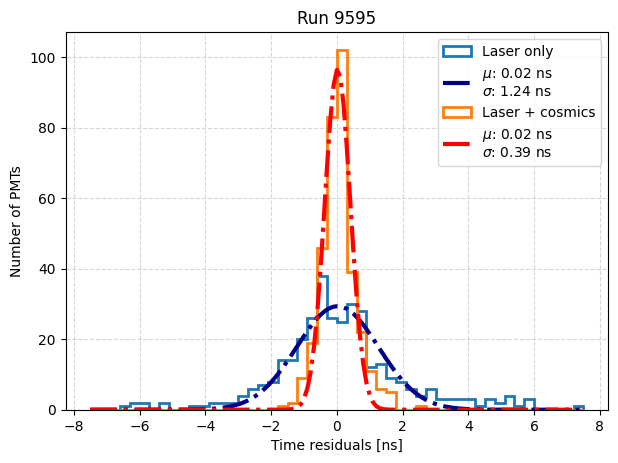

In [6]:
## Plotting residuals distribution with/without corrections
fig = plt.figure(figsize=(7,5),dpi=100)

rmin=-7.5
rmax=7.5
r=(rmin,rmax)
s=0.3
b=int((rmax-rmin)/s)

#xs1, ys1, param1, param_errors1 = fitGaussian(dfnolaser,BINSIZE=s,RMIN=rmin,RMAX=rmax)
xs2, ys2, param2, param_errors2 = fitGaussian(dflaser,BINSIZE=s,RMIN=rmin,RMAX=rmax)
xs3, ys3, param3, param_errors3 = fitGaussian(dfcosmics,BINSIZE=s,RMIN=rmin,RMAX=rmax)
xss = np.arange(rmin,rmax,0.1)

### PLOT DISTRIBUTIONS
#l_nolaser = "Base sample\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(dfnolaser.mean_residual_ns),np.std(dfnolaser.mean_residual_ns))
#l_laser = "Laser only\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(dflaser.mean_residual_ns),np.std(dflaser.mean_residual_ns))
#l_cosmics = "Laser + cosmics\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(dfcosmics.mean_residual_ns),np.std(dfcosmics.mean_residual_ns))
#plt.hist(dfnolaser.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l_nolaser)
#plt.hist(dflaser.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l_laser)
#plt.hist(dfcosmics.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l_cosmics)
#plt.legend()

### PLOT FITS
#l_nolaser = "Base sample"
#l_nolaserf= "$\mu$: {:.2f} ns\n$\sigma$: {:.2f} ns".format(param1[1],param1[2])
l_laser = "Laser only"
l_laserf = "$\mu$: {:.2f} ns\n$\sigma$: {:.2f} ns".format(param2[1],param2[2])
l_cosmics = "Laser + cosmics"
l_cosmicsf = "$\mu$: {:.2f} ns\n$\sigma$: {:.2f} ns".format(param3[1],param3[2])
#plt.hist(dfnolaser.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l_nolaser)
#plt.plot(xss,gaus(xss,*param1),"-.",color="darkblue",lw=3, label=l_nolaserf)
plt.hist(dflaser.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l_laser)
plt.plot(xss,gaus(xss,*param2),"-.",color="darkblue",lw=3, label=l_laserf)
plt.hist(dfcosmics.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l_cosmics)
plt.plot(xss,gaus(xss,*param3),"-.",color="red",lw=3, label=l_cosmicsf)
handles, labels = plt.gca().get_legend_handles_labels()
#order = [2,3,0,4,1] ## for just 2
order = [2,0,3,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 

### PLOT SINGLE
#l_cosmics = "Gaussian fit\n$\mu$: {:.2f} ns\n$\sigma$: {:.2f} ns".format(param3[1],param3[2])
#plt.hist(dfcosmics.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step")
#plt.plot(xss,gaus(xss,*param3),"-.",color="red",lw=3,label=l_cosmics)
#plt.xlim((-5,5))
#plt.legend()

plt.xlabel("Time residuals [ns]")
plt.ylabel("Number of PMTs")
plt.title("Run {}".format(run))
plt.grid(linestyle="dashed",alpha=0.5)
name = "../figs/timing_equalization_lasercosmics_run{}_w{}".format(run,corr)
plt.savefig(name+".png",dpi=100)
plt.show()

## Comparison between laser/cosmics residuals

In [49]:
LASERCORR="../inputs/laser_time_corrections_9772.csv"
COSMICSCORR="../output/residuals/Run_2/run{}_cosmics_timing_residuals.csv".format(corr)
VOLTAGE="../inputs/pmt_voltage_20221219.csv"
lasercorr = pd.read_csv(LASERCORR).set_index(["channel_id"])
voltage = pd.read_csv(VOLTAGE).set_index(["channel_id"])
thisdfg = pd.read_csv(COSMICSCORR).set_index(["channel_id"])
thisdfg = thisdfg.join( lasercorr[["t_signal", "A", "B", "C"]], on="channel_id" ) 
thisdfg = thisdfg.join( voltage, on="channel_id" ) 
thisdfg["laser_res"] = thisdfg.apply( lambda x : x.t_signal-(x.A+x.B*np.power(x.voltage, x.C) ) , axis=1)

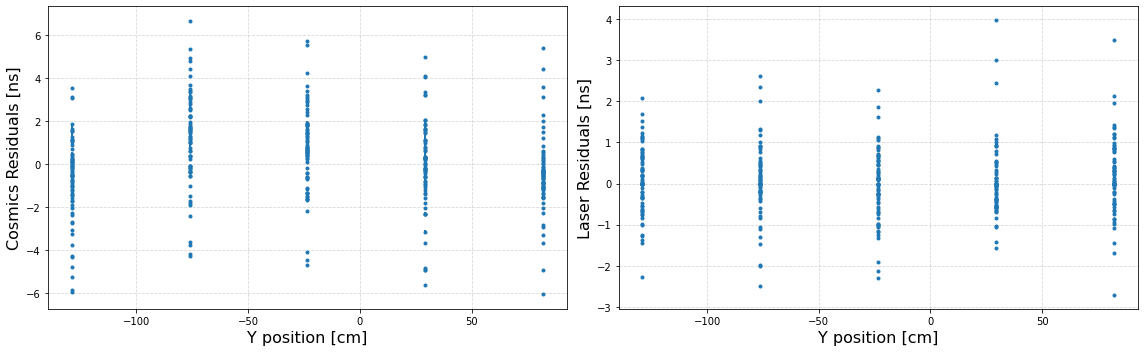

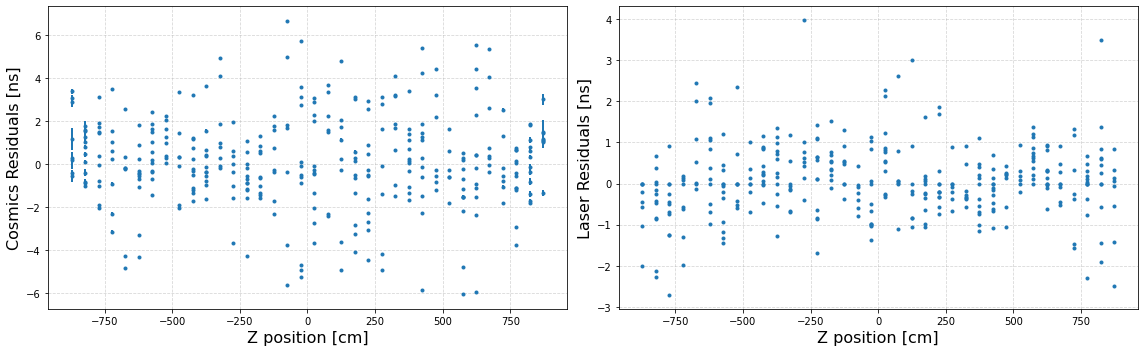

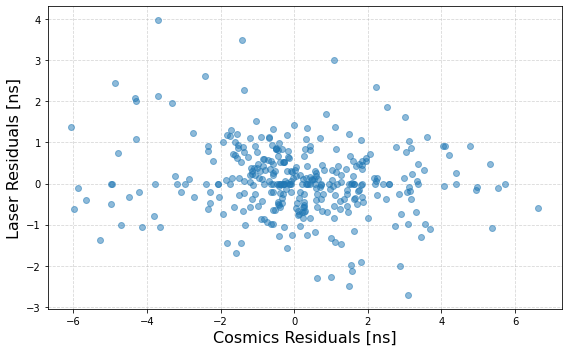

In [50]:
# Verify potential presence of biases 
fig, ax = plt.subplots(1,2, figsize=(16, 5))
ax[0].errorbar( x=thisdfg.y, y=thisdfg.mean_residual_ns, yerr=thisdfg.emean_ns, marker='.', elinewidth=2.0, lw=0 )
ax[1].errorbar( x=thisdfg.y, y=thisdfg.laser_res, yerr=0, marker='.', elinewidth=2.0, lw=0 )
ax[1].set_ylabel("Laser Residuals [ns]", fontsize=16)
ax[0].set_ylabel("Cosmics Residuals [ns]", fontsize=16)
ax[1].set_xlabel("Y position [cm]", fontsize=16)
ax[0].set_xlabel("Y position [cm]", fontsize=16)
plt.tight_layout()
ax[0].grid(alpha=0.5,linestyle="dashed")
ax[1].grid(alpha=0.5,linestyle="dashed")
plt.savefig("../figs/run{}_validation_laserVScomics_Y.png".format(corr),dpi=100)
plt.show()

fig, ax = plt.subplots(1,2, figsize=(16, 5))
ax[0].errorbar( x=thisdfg.z, y=thisdfg.mean_residual_ns, yerr=thisdfg.emean_ns, marker='.', elinewidth=2.0, lw=0 )
ax[1].errorbar( x=thisdfg.z, y=thisdfg.laser_res, yerr=0, marker='.', elinewidth=2.0, lw=0 )
ax[1].set_ylabel("Laser Residuals [ns]", fontsize=16)
ax[0].set_ylabel("Cosmics Residuals [ns]", fontsize=16)
ax[1].set_xlabel("Z position [cm]", fontsize=16)
ax[0].set_xlabel("Z position [cm]", fontsize=16)
plt.tight_layout()
ax[0].grid(alpha=0.5,linestyle="dashed")
ax[1].grid(alpha=0.5,linestyle="dashed")
plt.savefig("../figs/run{}_validation_laserVScomics_Z.png".format(corr),dpi=100)
plt.show()

# plot them togheter
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.errorbar( x=thisdfg.mean_residual_ns, y=thisdfg.laser_res, yerr=0, marker='o', elinewidth=2.0, lw=0, alpha=0.5 )
ax.set_ylabel("Laser Residuals [ns]", fontsize=16)
ax.set_xlabel("Cosmics Residuals [ns]", fontsize=16)

plt.tight_layout()
plt.grid(alpha=0.5,linestyle="dashed")
plt.savefig("../figs/run{}_validation_laserVScomics_2Dscatter.png".format(corr),dpi=100)
plt.show()

In [51]:
thisdfg[thisdfg.mean_residual_ns<-2].head()

,x,y,z,entries,pecut,mean_residual_ns,std_residual_ns,emean_ns,t_signal,A,B,C,voltage,on,laser_res
channel_id,,,,,,,,,,,,,,,
31,-371.0702,29.3500,-274.3399,87.0,300.0,-3.6961,2.9756,0.0342,255.917,214.773,3375.89,-0.609986,1623,1,3.978589
32,-371.0702,-129.0499,-224.4600,73.0,300.0,-4.3020,3.1185,0.0427,251.925,214.773,3375.89,-0.609986,1705,1,1.087355
39,-371.0702,29.3500,-124.7001,68.0,300.0,-2.3483,2.8637,0.0421,253.672,214.773,3375.89,-0.609986,1566,1,0.914183
45,-371.0702,-129.0499,24.9400,61.0,300.0,-2.7369,2.2620,0.0371,251.378,214.773,3375.89,-0.609986,1760,1,1.232073
47,-371.0702,82.1499,24.9400,85.0,300.0,-3.6954,2.9239,0.0344,254.251,214.773,3375.89,-0.609986,1610,1,2.129824


## Compare statistics

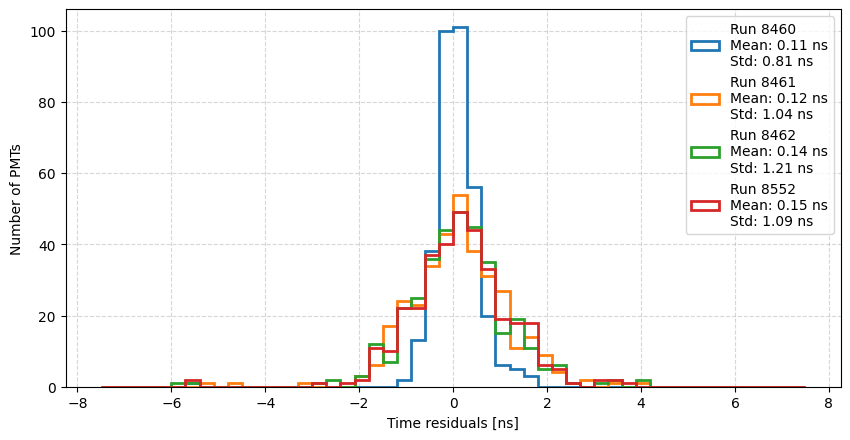

In [11]:
f1 = "../output/residuals/run8460_cosmics_timing_residuals_20230725.csv"
f2 = "../output/residuals/run8461_cosmics_timing_residuals_20230725.csv"
f3 = "../output/residuals/run8462_cosmics_timing_residuals_20230725.csv"
f4 = "../output/residuals/run8552_cosmics_timing_residuals_20230725.csv"

df1 = pd.read_csv(f1)
df2 = pd.read_csv(f2)
df3 = pd.read_csv(f3)
df4 = pd.read_csv(f4)

fig = plt.figure(figsize=(10,5),dpi=100)

l1 = "Run 8460\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(df1.mean_residual_ns),np.std(df1.mean_residual_ns))
l2 = "Run 8461\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(df2.mean_residual_ns),np.std(df2.mean_residual_ns))
l3 = "Run 8462\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(df3.mean_residual_ns),np.std(df3.mean_residual_ns))
l4 = "Run 8552\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(df4.mean_residual_ns),np.std(df4.mean_residual_ns))

plt.hist(df1.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l1)
plt.hist(df2.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l2)
plt.hist(df3.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l3)
plt.hist(df4.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l4)
plt.xlabel("Time residuals [ns]")
plt.ylabel("Number of PMTs")
plt.legend()
plt.grid(linestyle="dashed",alpha=0.5)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,5),dpi=100)

l1 = "Run 8460"
l2 = "Run 8461"
l3 = "Run 8462"
l4 = "Run 8552"
plt.hist(df1.entries, linewidth=2, histtype="step", label=l1)
plt.hist(df2.entries, linewidth=2, histtype="step", label=l2)
plt.hist(df3.entries, linewidth=2, histtype="step", label=l3)
plt.hist(df4.entries, linewidth=2, histtype="step", label=l4)
plt.xlabel("Entries per channel")
plt.ylabel("Number of PMTs")
plt.legend()
plt.grid(linestyle="dashed",alpha=0.5)
plt.show()

## Compare with different statistics

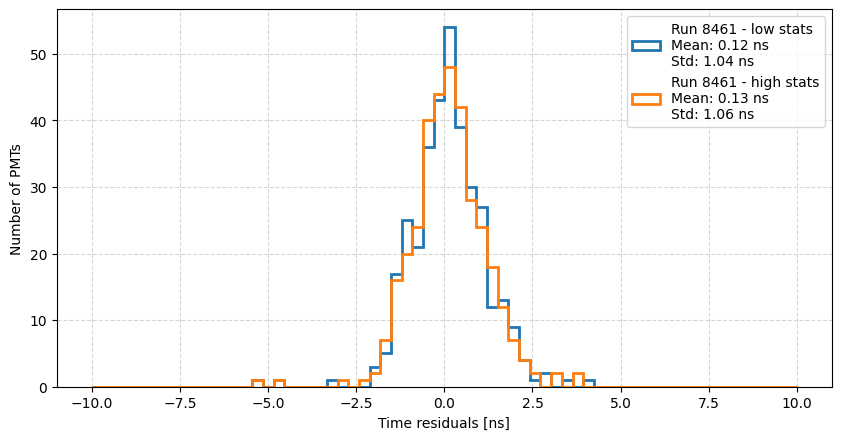

In [12]:
f1 = "../output/residuals/run8461_cosmics_timing_residuals_20230725.csv"
f2 = "../output/residuals/run8461_cosmics_timing_residuals_20230727.csv"

df1 = pd.read_csv(f1)
df2 = pd.read_csv(f2)

fig = plt.figure(figsize=(10,5),dpi=100)

l1 = "Run 8461 - low stats\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(df1.mean_residual_ns),np.std(df1.mean_residual_ns))
l2 = "Run 8461 - high stats\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(df2.mean_residual_ns),np.std(df2.mean_residual_ns))

plt.hist(df1.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l1)
plt.hist(df2.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l2)

plt.xlabel("Time residuals [ns]")
plt.ylabel("Number of PMTs")
plt.legend()
plt.grid(linestyle="dashed",alpha=0.5)
plt.show()

## Test old file cuts from Andrea

In [ ]:
f = "../output/run8413_matched_light_tracks_Andrea.txt"
df = pd.read_csv(f)
df.head()

In [ ]:
plt.hist( df.flashTime/1000 - df.trackTime/1000, histtype="step")
plt.show()

In [ ]:
plt.hist( df.flashLightZ - df.trackChargeZ, histtype = "step")
plt.show()